In [1]:
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext, SQLContext
import pandas as pd
import seaborn as sns


In [2]:
# You can configure the SparkContext

conf = SparkConf()
conf.set('spark.sql.shuffle.partitions', '2100')
conf.set("spark.executor.cores", "5")
SparkContext.setSystemProperty('spark.executor.memory', '10g')
SparkContext.setSystemProperty('spark.driver.memory', '10g')
sc = SparkContext(appName='mm_exp', conf=conf)
sqlContext = pyspark.SQLContext(sc)


In [3]:
metadata = sqlContext.read.json('/amazon/data/metadata.json.gz')
metadata.show()

NameError: name 'data' is not defined

In [5]:
review_data = sqlContext.read.json('/amazon/data/item_dedup.json.gz')
review_data.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|0000000078|  [1, 1]|    5.0|Conversations wit...|08 11, 2004|A3AF8FFZAZYNE5|                null|          Impactful!|    1092182400|
|0000000116|  [5, 5]|    4.0|Interesting Grish...|04 27, 2002| AH2L9G3DQHHAJ|               chris|  Show me the money!|    1019865600|
|0000000116|  [0, 0]|    1.0|The thumbnail is ...|03 24, 2014|A2IIIDRK3PRRZY|              Helene|Listing is all sc...|    1395619200|
|0000000868|[10, 10]|    4.0|I'll be honest. I...|09 11, 2002|A1TADCM7YWPQ8M|            Joel@AWS|Not a Bad Transla...|    1031702400|
|0000013714|  [0, 0]|    4.0|It had all the so...|10 31

In [6]:
metadata_pandas_df = metadata.limit(100).toPandas()
review_data_pandas_df = review_data.limit(100).toPandas()

In [82]:
review_data_pandas_df.to_csv('review_data_cutted.csv')

In [80]:
metadata_pandas_df.to_csv('metadata_cutted.csv')

In [15]:
df = pd.merge(review_data_pandas_df, metadata_pandas_df, on='asin', how='inner')

In [16]:
df

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,_corrupt_record,brand,categories,description,imUrl,price,related,salesRank,title
0,0000000116,"[5, 5]",4.0,Interesting Grisham tale of a lawyer that take...,"04 27, 2002",AH2L9G3DQHHAJ,chris,Show me the money!,1019865600,None,None,[[Books]],None,http://ecx.images-amazon.com/images/I/51Rbg%2B...,NaN,"(None, [B005U9T66K, B00602O7PG, B00HFXLAZE, B0...","(None, None, None, None, None, 10790794, None,...",Georgina Goodman Nelson Womens Size 8.5 Purple...
1,0000000116,"[0, 0]",1.0,The thumbnail is a shirt. The product shown i...,"03 24, 2014",A2IIIDRK3PRRZY,Helene,Listing is all screwed up,1395619200,None,None,[[Books]],None,http://ecx.images-amazon.com/images/I/51Rbg%2B...,NaN,"(None, [B005U9T66K, B00602O7PG, B00HFXLAZE, B0...","(None, None, None, None, None, 10790794, None,...",Georgina Goodman Nelson Womens Size 8.5 Purple...
2,0000000868,"[10, 10]",4.0,I'll be honest. I work for a large online reta...,"09 11, 2002",A1TADCM7YWPQ8M,Joel@AWS,Not a Bad Translation,1031702400,None,None,[[Books]],None,http://ecx.images-amazon.com/images/I/41K1RtF0...,21.85,None,"(None, None, None, None, None, 14161827, None,...",Foot Rot of Piper nigrum. L. (Phytopathologica...
3,0000013714,"[0, 0]",4.0,It had all the songs I wanted but I had ordere...,"10 31, 2013",AWGH7V0BDOJKB,Barbara Marshall,Not the large print,1383177600,None,None,[[Books]],None,http://ecx.images-amazon.com/images/I/51M1p2do...,8.09,"([0005080789, 0005476798, 0005476216, 00050643...","(None, None, None, None, None, 64393, None, No...",Heavenly Highway Hymns: Shaped-Note Hymnal
4,0000013714,"[0, 0]",5.0,"We have many of the old, old issue. But the nu...","07 27, 2013",A3UTQPQPM4TQO0,betty burnett,I was disappointed that you would only allow m...,1374883200,None,None,[[Books]],None,http://ecx.images-amazon.com/images/I/51M1p2do...,8.09,"([0005080789, 0005476798, 0005476216, 00050643...","(None, None, None, None, None, 64393, None, No...",Heavenly Highway Hymns: Shaped-Note Hymnal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,0000031887,"[0, 0]",5.0,I sent it to my granddaughter for her 4th birt...,"02 11, 2013",A2TWG16MB2V7VI,D. Doyle,my granddaughter loved it,1360540800,None,Boutique Cutie,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",This adorable basic ballerina tutu is perfect ...,http://ecx.images-amazon.com/images/I/314qZjYe...,6.79,"([0000031852, 0000031895, 0000031909, B00D2K1M...","(None, None, None, None, None, None, None, Non...",Ballet Dress-Up Fairy Tutu
88,0000031887,"[0, 0]",5.0,Very nice for the price! Washed by hand and he...,"12 10, 2013",A2DMMA8Q16GKM4,Debbie L Baranska,Very nice tutu,1386633600,None,Boutique Cutie,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",This adorable basic ballerina tutu is perfect ...,http://ecx.images-amazon.com/images/I/314qZjYe...,6.79,"([0000031852, 0000031895, 0000031909, B00D2K1M...","(None, None, None, None, None, None, None, Non...",Ballet Dress-Up Fairy Tutu
89,0000031887,"[0, 0]",4.0,These were a good buy - great color and qualit...,"06 12, 2013",A33CIS842YHGDM,Dec,"Good quality, good price...",1370995200,None,Boutique Cutie,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",This adorable basic ballerina tutu is perfect ...,http://ecx.images-amazon.com/images/I/314qZjYe...,6.79,"([0000031852, 0000031895, 0000031909, B00D2K1M...","(None, None, None, None, None, None, None, Non...",Ballet Dress-Up Fairy Tutu
90,0000031887,"[0, 0]",5.0,My daughter wore this at her first dance recit...,"07 12, 2013",AHUNCBKNI8HV8,DenverDiva,Perfect for her first recital,1373587200,None,Boutique Cutie,"[[Clothing, Shoes & Jewelry, Girls, Clothing, ...",This adorable basic ballerina tutu is perfect ...,http://ecx.images-amazon.com/images/I/314qZjYe...,6.79,"([0000031852, 0000031895, 0000031909, B00D2K1M...","(None, None, None, None, None, None, None, Non...",Ballet Dress-Up Fairy Tutu


In [51]:
flat_categories_df = pd.DataFrame(columns=['asin','category', 'reviewTime', 'overall', 'reviewerID', 'price', 'title'])

In [54]:
for index, row in df.iterrows():
    if row['categories'] is None:
        flat_categories_df = flat_categories_df.append({'asin': row['asin'], 
                                                        'category': None,
                                                        'reviewTime': row['reviewTime'],
                                                        'overall': row['overall'],
                                                        'reviewerID': row['reviewerID'],
                                                        'price': row['price'],
                                                        'title': row['title']}, 
                                                        ignore_index=True)
        continue
    for category in row['categories'][0]:
        flat_categories_df = flat_categories_df.append({'asin': row['asin'], 
                                                        'category': category,
                                                        'reviewTime': row['reviewTime'],
                                                        'overall': row['overall'],
                                                        'reviewerID': row['reviewerID'],
                                                        'price': row['price'],
                                                        'title': row['title']}, 
                                                        ignore_index=True)


In [73]:
flat_categories_df['reviewTime'] = pd.to_datetime(flat_categories_df['reviewTime']).dt.to_period('M')

In [74]:
flat_categories_df

,asin,category,reviewTime,overall,reviewerID,price,title
0,0000000116,Books,2002-04,4.0,AH2L9G3DQHHAJ,NaN,Georgina Goodman Nelson Womens Size 8.5 Purple...
1,0000000116,Books,2014-03,1.0,A2IIIDRK3PRRZY,NaN,Georgina Goodman Nelson Womens Size 8.5 Purple...
2,0000000868,Books,2002-09,4.0,A1TADCM7YWPQ8M,21.85,Foot Rot of Piper nigrum. L. (Phytopathologica...
3,0000013714,Books,2013-10,4.0,AWGH7V0BDOJKB,8.09,Heavenly Highway Hymns: Shaped-Note Hymnal
4,0000013714,Books,2013-07,5.0,A3UTQPQPM4TQO0,8.09,Heavenly Highway Hymns: Shaped-Note Hymnal
...,...,...,...,...,...,...,...
373,0000031887,"Clothing, Shoes & Jewelry",2014-05,5.0,A16GFPNVF4Y816,6.79,Ballet Dress-Up Fairy Tutu
374,0000031887,Girls,2014-05,5.0,A16GFPNVF4Y816,6.79,Ballet Dress-Up Fairy Tutu
375,0000031887,Clothing,2014-05,5.0,A16GFPNVF4Y816,6.79,Ballet Dress-Up Fairy Tutu
376,0000031887,Active,2014-05,5.0,A16GFPNVF4Y816,6.79,Ballet Dress-Up Fairy Tutu


[Text(0, 0, 'Books'),
 Text(1, 0, 'Sports & Outdoors'),
 Text(2, 0, 'Other Sports'),
 Text(3, 0, 'Dance'),
 Text(4, 0, 'Clothing, Shoes & Jewelry'),
 Text(5, 0, 'Girls'),
 Text(6, 0, 'Clothing'),
 Text(7, 0, 'Active'),
 Text(8, 0, 'Active Skirts')]

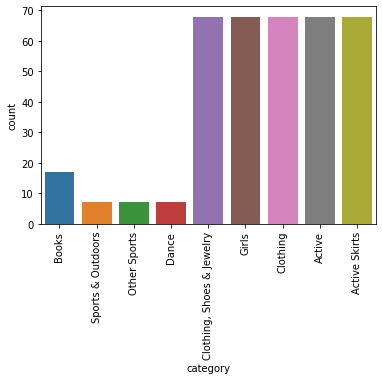

In [75]:
g = sns.countplot(data=flat_categories_df, x='category')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [77]:
final = pd.DataFrame(flat_categories_df.groupby(['category','reviewTime'])['overall'].mean())

In [78]:
final

overall
category          reviewTime         
Active            2010-03         4.0
                  2010-07         5.0
                  2010-10         5.0
                  2011-02         5.0
                  2011-11         3.0
...                               ...
Sports & Outdoors 2013-12         4.5
                  2014-01         4.0
                  2014-02         4.0
                  2014-04         1.0
                  2014-05         4.5

[175 rows x 1 columns]